In [1]:
import numpy as np

In [2]:
import scipy 
import pandas as pd
import matplotlib.pyplot as plt
import sys
from numpy import linalg
from sklearn.mixture import GaussianMixture
import numpy as np
from scipy import stats
# from mayavi import mlab
import seaborn as sns
from scipy.stats import gamma
from scipy.stats import norm
from scipy.stats import uniform

In [5]:
import seaborn as sns


In [6]:
from scipy.stats import gaussian_kde

In [7]:
def get_distribution_object(id = 1):
    d_dict = {}
    d_dict[1] = {
        'x': gamma(a = 2, loc= 1.0, scale=0.5),
        'y': gamma(a = 1, loc=-1.0, scale=0.75),
    }
    d_dict[2] = {
        'x': gamma(a = 1.0, loc = -1.5, scale=0.5),
        'y': gamma(a = 2.0, loc = 1.50, scale=0.5),
       
    }
    d_dict[3] = {
        'x': norm(loc = 2.75, scale =0.25),
        'y': norm(loc = 2.75, scale =0.25),
        
    }
    return d_dict[id]


def sample_from_dist(id = 1, size=500):
    obj = get_distribution_object(id)
    x = obj['x'].rvs(size=size)
    y = obj['y'].rvs(size=size)
    xy= np.vstack([x,y]).transpose()
    return xy


(30, 30)
(30, 30)
(30, 30)


/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: The following kwargs were not used by contour: 'lw'
  del sys.path[0]
/home/ddatta/anaconda3/envs/SG/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: The following kwargs were not used by contour: 'lw'
  


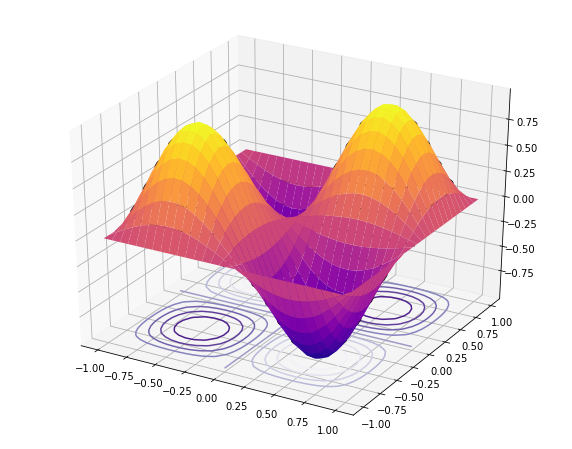

In [8]:
import numpy as np
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt

fig = plt.figure(figsize=[10,8])
ax = fig.add_subplot(111, projection="3d")
X, Y = np.mgrid[-1:1:30j, -1:1:30j]
print(X.shape)
print(Y.shape)
Z = np.sin(np.pi*X)*np.sin(np.pi*Y)
print(Z.shape)
ax.plot_surface(X, Y, Z, cmap="plasma", lw=0.5, rstride=1, cstride=1)
ax.contour(X, Y, Z, 10, lw=3, cmap="Purples", linestyles="solid", offset=-1)
ax.contour(X, Y, Z, 10, lw=3, colors="k", linestyles="solid")
plt.show()

In [9]:
X1 = sample_from_dist(id = 1,size = 1000)
X2 = sample_from_dist(id = 2,size = 1000)
X3 = sample_from_dist(id = 3,size = 200)

In [11]:
def  plot_fig_v2(xyz_list , cmaps = None , text_annotations = None):
    
    import numpy as np
    from mpl_toolkits.mplot3d import axes3d
    import matplotlib.pyplot as plt
    
    fig = plt.figure(figsize=[16,12])
    ax = fig.gca(projection='3d')
    ax.set_facecolor('xkcd:white')
    ax.grid('major')
    ax.view_init(elev=20, azim=45)

    if cmaps is None:
        cmaps = ['ocean', 'inferno',"plasma" ]
    i = 0
    j = 0
    for _xyz in xyz_list:
        
        x = _xyz[:,0]
        y = _xyz[:,1]
        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
       
        ax.plot_trisurf(x, y,z, cmap=cmaps[i], linewidth=0.2)
        i = (i+1)% len(cmaps)
        
        ax.text(np.median(x) + 0.75, np.median(y),  np.max(z) + 0.2, text_annotations[j], fontsize=28)
        j += 1
                    
    plt.xlabel('X-Axis', fontsize=24)
    plt.ylabel('Y-Axis', fontsize=24)
    plt.tight_layout()
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.savefig('viz_1.pdf')
    plt.show()
    
    
        
    return 

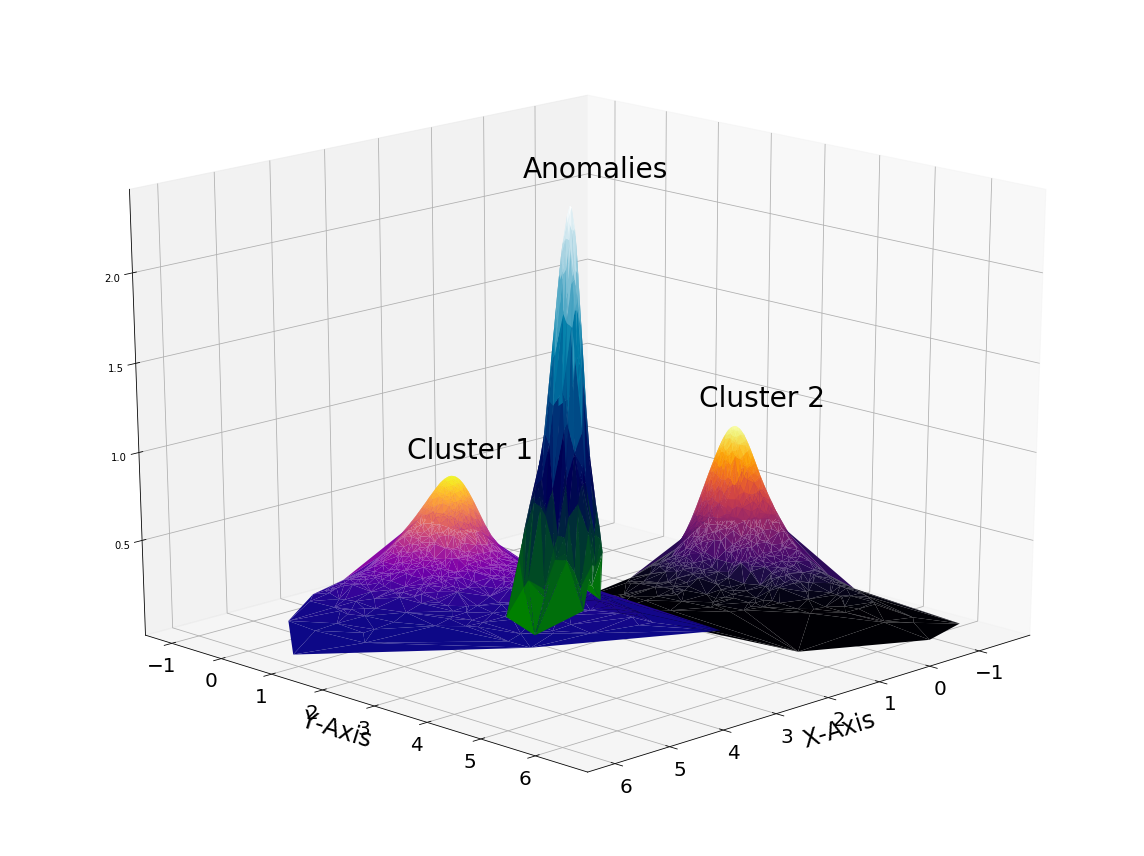

In [12]:
plot_fig_v2([X1,X2,X3], cmaps = ['plasma', 'inferno','ocean'], text_annotations = ['Cluster 1', 'Cluster 2', 'Anomalies'])


In [19]:
data = np.vstack([X1,X2])
anomaly_data =  X3
print('Data shapes', data.shape, anomaly_data.shape )

Data shapes (2000, 2) (200, 2)


In [20]:
def calculate_sample_energy(z , phi, mu, cov):
    e = 0
    num_comp = phi.shape[0]
    for k in range(num_comp):
        _mu = np.reshape(mu[0],[-1,1])
        p1 = z.reshape([-1,1]) - _mu 
        p2 = np.linalg.inv(cov[k])
        a = -0.5 * np.matmul( np.matmul ( p1.transpose(), p2), p1 )[0][0]
        b = np.exp(a)
        c = np.sqrt(2 * np.pi * np.linalg.det(cov[k]))
        e_k = phi[k] * b / c
        e += e_k
        
    e = - np.log(e)
    return e 

In [21]:
# ==========================
#  Split normal data
# ==========================
from sklearn.model_selection import train_test_split

train_X, test_X = train_test_split(data,test_size=0.25)

In [22]:
train_X.shape

(1500, 2)

In [23]:
# ================
# Train model 
# ================
gmm = GaussianMixture(n_components=2, covariance_type='full')
gmm.fit(train_X)
cov = gmm.covariances_
mu = gmm.means_
phi = gmm.weights_

In [40]:
mu

array([[-1.00305024,  2.4390049 ],
       [ 1.96818169, -0.20625744]])

In [25]:
# ---------------------------------------------
# Calculate sample energy for each data point
# ---------------------------------------------
combined_labels = [ 0 for _ in range (test_X.shape[0]) ] + [ 1 for _ in range (anomaly_data.shape[0]) ] 

In [26]:
anomaly_data.shape[0]

200

In [27]:
normal_data_energy = []
for x in test_X:
    e = calculate_sample_energy(x , phi, mu, cov)
    
    normal_data_energy.append(e)

In [28]:
anom_data_energy = []
for x in anomaly_data:
    e = calculate_sample_energy(x , phi, mu, cov)
    anom_data_energy.append(e)

In [29]:
combined_scores = normal_data_energy + anom_data_energy

In [30]:
res_df = pd.DataFrame(data = np.vstack([combined_scores,combined_labels]).transpose(), columns=['score','label'])


def normalize_values(v,_max,_min):
    return (v - _min) / ( _max - _min)

_min = min(combined_scores)
_max = max(combined_scores)

res_df['score'] = res_df['score'].apply(normalize_values,args=(_max,_min))

_min = min(res_df['score'])
_max = max(res_df['score'])

In [31]:
res_df

,score,label
0,0.004841,0.0
1,0.197502,0.0
2,0.026251,0.0
3,0.005111,0.0
4,0.519744,0.0
...,...,...
695,0.338096,1.0
696,0.423359,1.0
697,0.353881,1.0
698,0.349466,1.0


In [32]:
step = 0.01
threshold = _max -step
total_anom_count = anomaly_data.shape[0]
R = [0]
P = []
while threshold > _min:
    sel = res_df.loc[res_df['score']>=threshold]

    correct = len(sel.loc[sel['label'] == 1])
    selected = len(sel)
    prec = correct/selected
    recall = correct/total_anom_count
  
    threshold -=step
    P.append(prec)
    R.append(recall)
P = [P[0]] + P

In [33]:
from sklearn.metrics import auc


In [34]:
auc(R,P)

0.3650310956270184

# ----------------------------------------------------- #

In [35]:
def generate_neg_samples(dist_obj_list, min_x = -5, max_x =5, min_y = -5, max_y = +5, n_samples = 15000):
    n_dist_obj = {
        'x': uniform(loc = min_x, scale = max_x - min_x),
        'y': uniform(loc = min_y, scale = max_y - min_y),
    }
    res = []
    count = 0
    while count < n_samples:
        _x = n_dist_obj['x'].rvs(size=1)[0]
        _y = n_dist_obj['y'].rvs(size=1)[0]
        accept = True
        for D in dist_obj_list:
            p = D['x'].pdf(_x) *  D['y'].pdf(_y) 
            if p > 0.05:
                accept = False
        if accept:
            res.append([_x,_y])
            count +=1
    return np.array(res)
    
    

In [36]:
dist_obj_list = [ get_distribution_object(id = 1), get_distribution_object(id = 2)]

In [37]:
neg_Samples = generate_neg_samples(dist_obj_list )

In [38]:
plot_fig([X1, X2, neg_Samples])

NameError: name 'plot_fig' is not defined

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC

In [ ]:
# clf = MLPClassifier(
#     hidden_layer_sizes=(2,2,),
#     activation='tanh',
#     learning_rate='adaptive',
#     verbose = True
# )

clf = SVC(probability=True)

              

In [ ]:
clf_train_X = np.vstack([train_X, neg_Samples])

In [ ]:
clf_train_Y = np.array( [1  for _ in range(train_X.shape[0]) ] + [0 for _ in range(neg_Samples.shape[0]) ] )

In [ ]:
clf.fit(clf_train_X,clf_train_Y,  )

In [ ]:
test_X_scores = list(clf.predict_proba(test_X)[:,0].reshape(-1))

anom_scores = list(clf.predict_proba(anomaly_data)[:,0].reshape(-1))

In [ ]:
anom_scores

In [ ]:
test_X_scores

In [ ]:
combined_scores =  test_X_scores + anom_scores

In [ ]:
combined_labels = [ 0 for _ in range (test_X.shape[0]) ] + [ 1 for _ in range (anomaly_data.shape[0]) ] 
res_df = pd.DataFrame(
    data = np.vstack([combined_scores,combined_labels]).transpose(), 
    columns=['score','label']
)

def normalize_values(v,_max,_min):
    return (v - _min) / ( _max - _min)

_min = min(combined_scores)
_max = max(combined_scores)

res_df['score'] = res_df['score'].apply(normalize_values,args=(_max,_min))

_min = min(res_df['score'])
_max = max(res_df['score'])
print(_min,_max)

In [ ]:
step = 0.01
threshold = _max - step
total_anom_count = anomaly_data.shape[0]
R = [0]
P = []

In [ ]:
while threshold >_min:
    sel = res_df.loc[res_df['score']>=threshold]
    correct = len(sel.loc[sel['label'] == 1])
    selected = len(sel)
   
    prec = correct/selected
    recall = correct/total_anom_count
#     print(threshold, selected, prec, recall)
    threshold -=step
    P.append(prec)
    R.append(recall)

P = [P[0]] + P
print(auc(R,P))